# PyTorch-Only Notebook: Production-Style Character-Level Name Model

This notebook is **100% PyTorch-native**:
- No custom `Linear`, no custom `BatchNorm1d`, no manual parameter lists.
- We use `torch.nn`, `torch.utils.data`, `torch.optim`, and clean training/eval loops.

## What you will learn (production mindset)
1. **Project setup & reproducibility**
2. **Data pipeline**: `Dataset` + `DataLoader` (train/dev/test)
3. **Modeling**:
   - Embedding
   - MLP / deeper MLP
   - BatchNorm / Dropout (optional)
4. **Proper initialization** (practical modern defaults + explicit init)
5. **Training loop**:
   - train/eval modes
   - gradient clipping
   - LR scheduler
   - checkpointing best dev model
6. **Evaluation**:
   - loss on train/dev/test
7. **Inference / Sampling**:
   - temperature
   - generating names
8. **Lightweight hyperparameter tuning**:
   - small search over a few configs
   - clean result table

 **Goal:** Learn production-style PyTorch by building a clean char-level name model.

## What this notebook does
We will build a complete workflow using only PyTorch:
- **Data pipeline**: `Dataset` + `DataLoader`
- **Model**: `nn.Embedding` + MLP (with options like BatchNorm/Dropout)
- **Initialization**: practical modern initialization via `torch.nn.init`
- **Training**: train/eval loops, optimizer, scheduler, gradient clipping
- **Evaluation**: train/dev/test loss
- **Inference**: sampling names with temperature
- **Hyperparameter tuning**: small, structured search and a results table

## Design principles (professional)
- Reproducible runs (seeds, deterministic-ish settings)
- Clear configuration objects
- No global state surprises
- Clean separation: data / model / training / eval / inference

In [1]:
# Imports, reproducibility, device, and repo paths (production baseline)

from __future__ import annotations

import math
import os
import random
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility utilities
# -------------------------
SEED = 1337

def seed_all(seed: int = SEED) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    # NOTE: On MPS, determinism is not guaranteed like CUDA deterministic modes,
    # but setting seeds still provides good reproducibility for learning.
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_all(SEED)

# device selection (Mac: MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

# repo root resolution (consistent with your prior notebooks)
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / "data").exists() and (REPO_ROOT.parent / "data").exists():
    REPO_ROOT = REPO_ROOT.parent

data_path = REPO_ROOT / "data" / "names.txt"
assert data_path.exists(), f"names.txt not found at: {data_path}"

print("repo root:", REPO_ROOT)
print("data path:", data_path)

device: mps
repo root: /Users/home/Developer/github/makemore-notes
data path: /Users/home/Developer/github/makemore-notes/data/names.txt


In [2]:
# Load data, build vocabulary, and deterministic train/dev/test split

words = data_path.read_text(encoding="utf-8").splitlines()
print("num words:", len(words))
print("sample:", words[:5])

# Build vocabulary ('.' -> 0)
chars = sorted(set("".join(words)))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)

print("vocab_size:", vocab_size)
print("itos (first 10):", list(itos.items())[:10])

# deterministic shuffle
rng = torch.Generator().manual_seed(SEED)
perm = torch.randperm(len(words), generator=rng).tolist()
words_shuf = [words[i] for i in perm]

# splits
n1 = int(0.8 * len(words_shuf))
n2 = int(0.9 * len(words_shuf))
words_tr = words_shuf[:n1]
words_dev = words_shuf[n1:n2]
words_te = words_shuf[n2:]

print("splits:", len(words_tr), len(words_dev), len(words_te))

num words: 32033
sample: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
vocab_size: 27
itos (first 10): [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f'), (7, 'g'), (8, 'h'), (9, 'i'), (10, 'j')]
splits: 25626 3203 3204


In [3]:
# PyTorch Dataset (context windows) + DataLoaders

class NameDataset(Dataset):
    """
    Character-level dataset that produces:
      X: (block_size,) context indices
      Y: next character index
    """
    def __init__(self, words: List[str], stoi: Dict[str, int], block_size: int):
        self.stoi = stoi
        self.block_size = block_size
        self.X, self.Y = self._build(words)

    def _build(self, words: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        X, Y = [], []
        for w in words:
            context = [0] * self.block_size
            for ch in w + ".":
                ix = self.stoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix]
        X = torch.tensor(X, dtype=torch.long)
        Y = torch.tensor(Y, dtype=torch.long)
        return X, Y

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.Y[idx]


# configuration
block_size = 3
batch_size = 64

# datasets
train_ds = NameDataset(words_tr, stoi, block_size)
dev_ds   = NameDataset(words_dev, stoi, block_size)
test_ds  = NameDataset(words_te, stoi, block_size)

# dataloaders
pin_memory = (device.type == 'cuda')  # only meaningful for CUDA

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory
)
dev_loader = DataLoader(
    dev_ds, batch_size=batch_size, shuffle=False, pin_memory=pin_memory
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, pin_memory=pin_memory
)

print("train batches:", len(train_loader))
print("example batch shapes:", next(iter(train_loader))[0].shape)

train batches: 2852
example batch shapes: torch.Size([64, 3])


In [4]:
# Model config + PyTorch MLP model + professional initialization

@dataclass(frozen=True)
class MLPConfig:
    vocab_size: int
    block_size: int
    n_embed: int = 16
    n_hidden: int = 256
    n_layers: int = 2          # number of hidden Linear layers (after embedding/flatten)
    dropout: float = 0.0
    use_batchnorm: bool = True

cfg = MLPConfig(vocab_size=vocab_size, block_size=block_size)
cfg

MLPConfig(vocab_size=27, block_size=3, n_embed=16, n_hidden=256, n_layers=2, dropout=0.0, use_batchnorm=True)

In [5]:
# Build the PyTorch model (nn.Module) using cfg (Embedding + MLP stack)

class CharMLP(nn.Module):
    def __init__(self, cfg: MLPConfig):
        super().__init__()
        self.cfg = cfg

        self.embed = nn.Embedding(cfg.vocab_size, cfg.n_embed)

        layers: List[nn.Module] = []
        in_dim = cfg.block_size * cfg.n_embed

        for i in range(cfg.n_layers):
            layers.append(nn.Linear(in_dim if i == 0 else cfg.n_hidden, cfg.n_hidden, bias=True))
            if cfg.use_batchnorm:
                layers.append(nn.BatchNorm1d(cfg.n_hidden, momentum=0.1, eps=1e-5, affine=True))
            layers.append(nn.Tanh())
            if cfg.dropout > 0:
                layers.append(nn.Dropout(cfg.dropout))

        self.mlp = nn.Sequential(*layers)
        self.head = nn.Linear(cfg.n_hidden, cfg.vocab_size, bias=True)

        self.apply(self._init_weights)  # professional init hook

    def _init_weights(self, m: nn.Module):
        """
        Practical initialization:
        - Embedding: small N(0, 0.1) works better with tanh/BN for stable early training.
        - Linear: Xavier (good for tanh), bias = 0.
        - BatchNorm: gamma=1, beta=0 (PyTorch default).
        """
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)  # tanh-friendly
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.1)  # smaller std avoids tanh saturation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T)
        x = self.embed(x)                # (B, T, n_embed)
        x = x.view(x.shape[0], -1)       # (B, T*n_embed)
        x = self.mlp(x)                  # (B, n_hidden)
        logits = self.head(x)            # (B, vocab_size)
        return logits


model = CharMLP(cfg).to(device)
print(model)
print("num params:", sum(p.numel() for p in model.parameters()))

CharMLP(
  (embed): Embedding(27, 16)
  (mlp): Sequential(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
  )
  (head): Linear(in_features=256, out_features=27, bias=True)
)
num params: 86731


In [6]:
# Train/eval utilities (clean, production-style)

non_blocking = (device.type == 'cuda')

@torch.no_grad()
def evaluate_loss(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    total_loss = 0.0
    total_count = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=non_blocking)
        yb = yb.to(device, non_blocking=non_blocking)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction="sum")
        total_loss += loss.item()
        total_count += yb.numel()

    return total_loss / total_count


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    *,
    grad_clip: float | None = 1.0,
) -> float:
    model.train()
    total_loss = 0.0
    total_count = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=non_blocking)
        yb = yb.to(device, non_blocking=non_blocking)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()

        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

        optimizer.step()

        total_loss += loss.item() * yb.numel()
        total_count += yb.numel()

    return total_loss / total_count


print("train/eval utilities ready")

train/eval utilities ready


In [7]:
# Full training loop (AdamW + scheduler + best-dev checkpoint)

@dataclass
class TrainConfig:
    epochs: int = 15
    lr: float = 3e-3
    weight_decay: float = 1e-2
    grad_clip: float | None = 1.0
    scheduler: str = "cosine"  # "none" or "cosine"

tcfg = TrainConfig()
tcfg

TrainConfig(epochs=15, lr=0.003, weight_decay=0.01, grad_clip=1.0, scheduler='cosine')

In [8]:
# Train the model with best-checkpoint (in-memory) and logging

def make_scheduler(optimizer: torch.optim.Optimizer, tcfg: TrainConfig):
    if tcfg.scheduler == "none":
        return None
    if tcfg.scheduler == "cosine":
        # Cosine annealing across epochs (simple, robust)
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=tcfg.epochs)
    raise ValueError(f"Unknown scheduler: {tcfg.scheduler}")

seed_all(SEED)  # ensure reproducible init/training
model = CharMLP(cfg).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=tcfg.lr, weight_decay=tcfg.weight_decay)
scheduler = make_scheduler(optimizer, tcfg)

best = {"dev_loss": float("inf"), "state_dict": None, "epoch": -1}
log = {"epoch": [], "train_loss": [], "dev_loss": [], "lr": []}

for epoch in range(1, tcfg.epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, grad_clip=tcfg.grad_clip)
    dev_loss = evaluate_loss(model, dev_loader)

    if scheduler is not None:
        scheduler.step()

    current_lr = optimizer.param_groups[0]["lr"]
    log["epoch"].append(epoch)
    log["train_loss"].append(train_loss)
    log["dev_loss"].append(dev_loss)
    log["lr"].append(current_lr)

    if dev_loss < best["dev_loss"]:
        best["dev_loss"] = dev_loss
        best["epoch"] = epoch
        # store a CPU copy (portable)
        best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"epoch {epoch:02d} | lr {current_lr:.3g} | train {train_loss:.4f} | dev {dev_loss:.4f} | best_dev {best['dev_loss']:.4f} (ep {best['epoch']})")

print("done. best dev:", best["dev_loss"], "at epoch", best["epoch"])


epoch 01 | lr 0.00297 | train 2.3375 | dev 2.2588 | best_dev 2.2588 (ep 1)
epoch 02 | lr 0.00287 | train 2.2219 | dev 2.1960 | best_dev 2.1960 (ep 2)
epoch 03 | lr 0.00271 | train 2.1782 | dev 2.1659 | best_dev 2.1659 (ep 3)
epoch 04 | lr 0.0025 | train 2.1533 | dev 2.1515 | best_dev 2.1515 (ep 4)
epoch 05 | lr 0.00225 | train 2.1359 | dev 2.1390 | best_dev 2.1390 (ep 5)
epoch 06 | lr 0.00196 | train 2.1211 | dev 2.1262 | best_dev 2.1262 (ep 6)
epoch 07 | lr 0.00166 | train 2.1076 | dev 2.1207 | best_dev 2.1207 (ep 7)
epoch 08 | lr 0.00134 | train 2.0941 | dev 2.1114 | best_dev 2.1114 (ep 8)
epoch 09 | lr 0.00104 | train 2.0804 | dev 2.1046 | best_dev 2.1046 (ep 9)
epoch 10 | lr 0.00075 | train 2.0684 | dev 2.0980 | best_dev 2.0980 (ep 10)
epoch 11 | lr 0.000496 | train 2.0550 | dev 2.0942 | best_dev 2.0942 (ep 11)
epoch 12 | lr 0.000286 | train 2.0437 | dev 2.0881 | best_dev 2.0881 (ep 12)
epoch 13 | lr 0.00013 | train 2.0343 | dev 2.0824 | best_dev 2.0824 (ep 13)
epoch 14 | lr 3.28e-

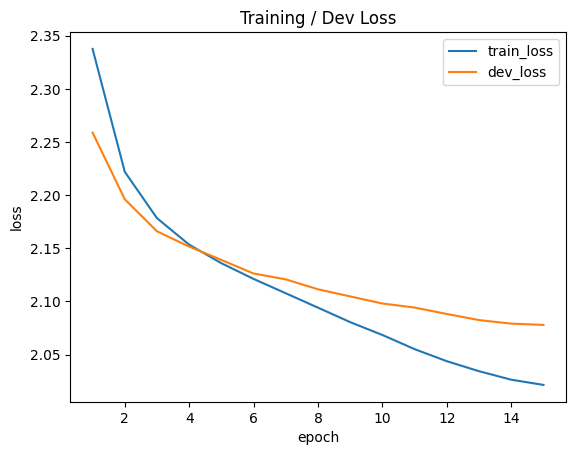

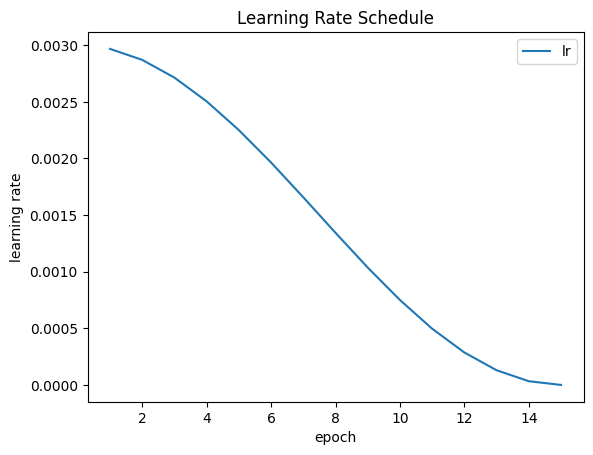

In [9]:
# Plot training curves (sanity check)

import matplotlib.pyplot as plt

assert "log" in globals(), "I can't find `log`. Make sure you ran the training cell first."

epochs = log.get("epoch", list(range(1, len(log.get("train_loss", [])) + 1)))
train_losses = log.get("train_loss", [])
dev_losses = log.get("dev_loss", [])
lrs = log.get("lr", [])

plt.figure()
plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, dev_losses, label="dev_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training / Dev Loss")
plt.legend()
plt.show()

if len(lrs) == len(epochs):
    plt.figure()
    plt.plot(epochs, lrs, label="lr")
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.show()

To be completed later...